###  Distribution similarity-based classification based on PCA

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
RANDOM_SEED = 110011

In [2]:
adata = sc.read_h5ad('../data/h5ab_folder/gse159812_raw_covid_normalized_preprocessed.h5ad')
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# Delete 'X_umap' for this experiment.
del adata.obsm['X_umap']
del adata.uns['neighbors']
del adata.uns['pca']
del adata.obsm['X_pca']
del adata.uns['umap']
del adata.varm['PCs']
del adata.obsp

In [4]:
from sklearn.model_selection import train_test_split
list_samples = list(adata.obs['sample'].unique())
y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=RANDOM_SEED)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Control_9', 'COVID-19_3', 'Influenza_2', 'COVID-19_15', 'COVID-19_10', 'Control_4', 'Control_6', 'Control_7', 'Control_5', 'COVID-19_1', 'COVID-19_5', 'Control_2', 'COVID-19_9', 'Control_11', 'COVID-19_7', 'Control_8', 'COVID-19_14', 'COVID-19_11', 'COVID-19_8', 'COVID-19_13', 'COVID-19_6', 'Control_10', 'Control_3', 'Control_12']
Samples for testing: ['COVID-19_2', 'Control_13', 'Control_1', 'COVID-19_4', 'COVID-19_12', 'Influenza_1']


Make a copied adata. Then get the cell bercode corresponding to the samples of the train data.

In [5]:
### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_train'] = adata.obs['sample'].isin(y_train)

# Copy adata
adata_train = adata.copy()
# Remove cells that don't belong to y_train
adata_train = adata_train[adata_train.obs['contain_y_train'] == True,:]


### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_test'] = adata.obs['sample'].isin(y_test)

# Copy adata
adata_test = adata.copy()
# Remove cells that don't belong to y_train
adata_test = adata_test[adata_test.obs['contain_y_test'] == True,:]

In [6]:
adata_train

View of AnnData object with n_obs × n_vars = 93881 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne'
    obsm: 'X_tsne'

In [7]:
adata_test

View of AnnData object with n_obs × n_vars = 20820 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train', 'contain_y_test'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne'
    obsm: 'X_tsne'

Apply UMAP to the train adata. Make sure both adata (train/refrence and test) have the same genes.

In [8]:
sc.pp.neighbors(adata_train, n_pcs = 30, n_neighbors = 20) 
sc.tl.pca(adata_train)
#sc.tl.umap(adata_train)
#sc.pl.umap(adata_train, color='sample')

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:27)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)


In [9]:
adata_train

AnnData object with n_obs × n_vars = 93881 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne', 'neighbors', 'pca'
    obsm: 'X_tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
#sc.tl.ingest(adata_test, adata_train, obs='sample', embedding_method='umap')
sc.tl.ingest(adata_test, adata_train, embedding_method='pca')

running ingest
    finished (0:00:05)


Concatenate both `adata_train` and `adata_test` for further analysis.

In [11]:
adata_concat = adata_train.concatenate(adata_test, batch_categories=['ref', 'new'])
adata = adata_concat.copy()

/home/dozonok/anaconda3/envs/workshop_scanpy_2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [12]:
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train', 'contain_y_test'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_tsne', 'X_pca'

In [13]:
adata.obsm['X_pca']

array([[  3.75332117, -13.42973423,  -8.4799118 , ...,  -1.23066509,
         -0.03090102,  -0.04365028],
       [  3.97920156, -12.97316742,   0.53989804, ...,   5.44768953,
          5.5370245 ,   1.08506036],
       [  1.53264534,  -9.95164013,  -0.66025674, ...,   0.28439558,
          1.09119725,   1.6256063 ],
       ...,
       [ -1.38636792,  -5.93393606,  -5.41239714, ...,   0.70302171,
         -1.16226008,  -0.21591247],
       [ -6.08839629,  11.88180297,   5.45091123, ...,   0.77287436,
         -0.22290325,  -0.93149814],
       [ -3.40205216,  -4.53180435,  -3.05604831, ...,   0.27345064,
          0.92889698,  -1.09758237]])

In [14]:
# Save adata
adata.obs.drop(columns=['contain_y_test', 'contain_y_train'], inplace=True)
save_file = '../data/h5ab_folder/ingest_gse159812_raw_covid_normalized_preprocessed_PCA.h5ad'
adata.write_h5ad(save_file)

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [15]:
list_samples = adata.obs['sample'].unique()

In [16]:
list_covid = ['COVID-19_9', 'COVID-19_1', 'COVID-19_11', 'COVID-19_8', 'COVID-19_3',
              'COVID-19_7', 'COVID-19_4', 'COVID-19_12', 'COVID-19_5', 'COVID-19_15',
               'COVID-19_14', 'COVID-19_2', 'COVID-19_6', 'COVID-19_10', 'COVID-19_13']
list_non_covid = ['Control_12', 'Control_2','Control_9', 'Influenza_2', 'Control_10',     
               'Control_13', 'Control_6', 'Control_11', 'Control_8', 'Control_7', 'Influenza_1',
               'Control_5', 'Control_4', 'Control_1', 'Control_3']

for index, row in adata.obs.iterrows():
     if row['sample'] in list_covid:
          new_value = 'covid'
     elif row['sample'] in list_non_covid:
          new_value = 'non_covid'

     adata.obs.at[index, 'covid_non_covid'] = new_value

In [17]:
print('Number of cells of all samples in covid and non covid.')
print(adata.obs['covid_non_covid'].value_counts())
# print('Number of cells of each sample in covid and non covid.')
# adata.obs.groupby('sample')['covid_non_covid'].count()

Number of cells of all samples in covid and non covid.
covid        60039
non_covid    54662
Name: covid_non_covid, dtype: int64


## Sample Classification: Scenario 1

### Input data
PCA representation (PCA 1 - PCA 2)

### Method
Get KDEs of covid and non-covid from PCA representation (PCA1~2), and compare them with a new sample cluster’s KDE by KL-divergence.


* Sample for making KDE of covid and non-covid: Sample obtained from `train_test_split` (80% of the total samples)
* Sample to measure how similar to two KDEs: Sample obtained from `train_test_split` (20% of the total samples)


### Hypothesis
There should be similarity between covid samples in KDE, and difference compared to non-covid samples. 

### Get PDE and KDE from PCA representation in sample making KDE of covid and non-covid

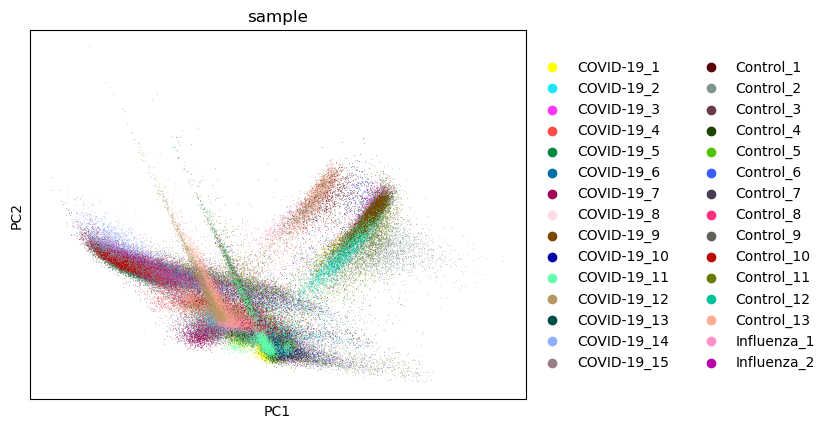

In [29]:
# Plot PCA representation
sc.pl.pca(adata, color='sample')
  

In [30]:
basis_values = adata.obsm['X_pca'][:, :2]

sample_vector = adata.obs['sample'].values
covid_non_covid_vector = adata.obs['covid_non_covid'].values


df_pds = pd.DataFrame(list(zip(basis_values, sample_vector, covid_non_covid_vector)),
               columns =['basis_value', 'sample', 'covid_non_covid'])

In [31]:
df_pds

,basis_value,sample,covid_non_covid
0,"[3.7533211708068848, -13.429734230041504]",COVID-19_1,covid
1,"[3.979201555252075, -12.973167419433594]",COVID-19_1,covid
2,"[1.532645344734192, -9.951640129089355]",COVID-19_1,covid
3,"[0.575897753238678, -8.628656387329102]",COVID-19_1,covid
4,"[3.398256540298462, -12.020442962646484]",COVID-19_1,covid
...,...,...,...
114696,"[8.101748543398035, 13.275000602768772]",COVID-19_12,covid
114697,"[-11.124620946498428, 18.713409963723393]",COVID-19_12,covid
114698,"[-1.3863679180231596, -5.933936059492354]",COVID-19_12,covid
114699,"[-6.08839628749764, 11.881802966568767]",COVID-19_12,covid


In [26]:
# from sklearn.model_selection import train_test_split

# y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=1777)

# print("Samples for making a KDE in existing samples:", y_train) # 24 samples
# print("Samples to measure how similar to two KDEs (for a test purpose):", y_test) # 6 samples

Get covid vectors and non-covid vectors from UMAP representation on the train (existing sample) data.

In [32]:
y_train = list(y_train)
y_test = list(y_test)

ext_covid_vector = df_pds.query("sample == @y_train and sample.str.contains('COVID')")['basis_value'].values
ext_non_covid_vector = df_pds.query("sample == @y_train and not sample.str.contains('COVID')")['basis_value'].values

In [33]:
y_train = list(y_train)
y_test = list(y_test)

ext_covid_vector = df_pds.query("sample == @y_train and sample.str.contains('COVID')")['basis_value'].values
ext_non_covid_vector = df_pds.query("sample == @y_train and not sample.str.contains('COVID')")['basis_value'].values

new_covid_vector = []

for v in ext_covid_vector:
    new_covid_vector.append(list(v))

new_non_covid_vector = []

for v in ext_non_covid_vector:
    new_non_covid_vector.append(list(v))

ext_covid_vector = np.array(new_covid_vector)
ext_non_covid_vector = np.array(new_non_covid_vector)

print(f"Number of cells from selected covid samples: {len(ext_covid_vector)}")
print(f"Number of cells from selected non-covid samples: {len(ext_non_covid_vector)}")

Number of cells from selected covid samples: 48724
Number of cells from selected non-covid samples: 45157


In [34]:
x_covid = ext_covid_vector[:, 0]
y_covid = ext_covid_vector[:, 1]
x_n_covid = ext_non_covid_vector[:, 0]
y_n_covid = ext_non_covid_vector[:, 1]

# now determine nice limits by hand:
#binwidth = 0.25
binwidth = 1
xymax = np.max([np.max(np.fabs(x_covid)), np.max(np.fabs(y_covid))])
lim = (int(xymax/binwidth) + 1) * binwidth

kernel_x_covid = stats.gaussian_kde(x_covid)
kernel_y_covid = stats.gaussian_kde(y_covid)
kernel_x_n_covid = stats.gaussian_kde(x_n_covid)
kernel_y_n_covid = stats.gaussian_kde(y_n_covid)
n_sample_covid = np.linspace(-lim+5, lim+5, len(ext_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)
#n_sample_non_covid = np.linspace(-lim+5, lim+5, len(ext_covid_vector)) #(start, stop, num=50 -> Number of samples to generate. Default is 50. Must be non-negative)

# KDE for UMAP1 (x-axis)
kde_x_covid = kernel_x_covid(n_sample_covid)
kde_x_n_covid = kernel_x_n_covid(n_sample_covid)

# KDE for UMAP2 (y-axis)
kde_y_covid = kernel_y_covid(n_sample_covid)
kde_y_n_covid = kernel_y_n_covid(n_sample_covid)

Text(0.5, 1.0, 'KDE in UMAP2')

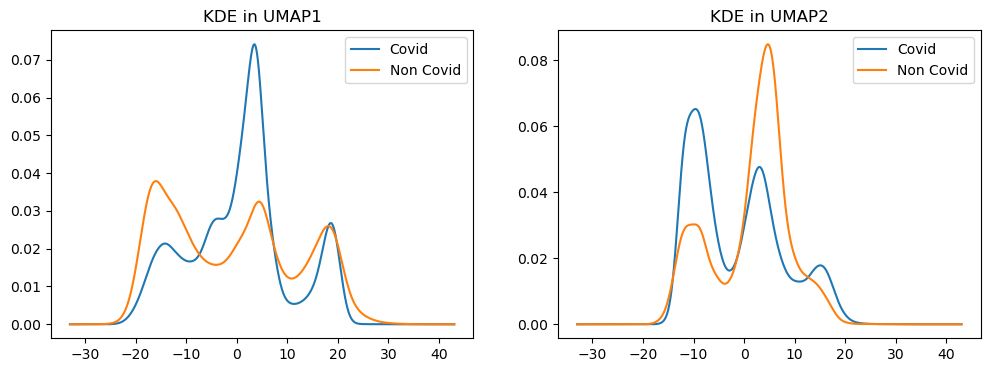

In [35]:
# Initialise the subplot function using number of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# For Covid KDE
ax1.plot(n_sample_covid, kde_x_covid, label='Covid')
ax1.plot(n_sample_covid, kde_x_n_covid, label='Non Covid')
ax1.legend()
ax1.set_title("KDE in UMAP1")

ax2.plot(n_sample_covid, kde_y_covid, label='Covid')
ax2.plot(n_sample_covid, kde_y_n_covid, label='Non Covid')
ax2.legend()
ax2.set_title("KDE in UMAP2")


### Plotting samples to measure how similar to two KDEs (UMAP1 and UMAP2) in test (new) samples

First, getting the vector of test samples from the UMAP representation.

In [36]:
print("Test samples:", y_test)

Test samples: ['COVID-19_2', 'Control_13', 'Control_1', 'COVID-19_4', 'COVID-19_12', 'Influenza_1']


In [37]:
#df_pds.query("sample == 'COVID-19_13' and sample.str.contains('COVID')")

In [38]:
dict_sample_vec = {} #Key: sample_name, value: basis value as [UMAP1, UMAP2]

for s in y_test:
    dict_sample_vec[s] = np.stack(list(df_pds.query(f"sample == '{s}'")['basis_value'].values[:]))
    print(f"Sample: {s}, size of vecor {len(dict_sample_vec[s])}")

Sample: COVID-19_2, size of vecor 2359
Sample: Control_13, size of vecor 4218
Sample: Control_1, size of vecor 2458
Sample: COVID-19_4, size of vecor 4561
Sample: COVID-19_12, size of vecor 4395
Sample: Influenza_1, size of vecor 2829


In [39]:
import numpy as np  
from scipy.stats import norm  
from matplotlib import pyplot as plt

#compute KL Divergence
"""KL Divergence(P|Q)"""
def KL_div(p_probs, q_probs):    
    KL_div = p_probs * np.log(p_probs / q_probs)
    return np.sum(KL_div)

result_UMAP1_pred = dict() # Key: sample_name, value: #[Comparison with the exsiting covid sample, Comarison with existing non-covid sample]
result_pred = dict() # Key: sample_name, value: #[Avg of the exsiting covid sample's KL-divergence score between UMAP1 and UMAP2, Avg of the exsiting non-covid sample's KL-divergence score between UMAP1 and UMAP2]

#### A. Compare the existing sample distributions with the test sample distributions based on KL-divergence.

Existing sample: covid, Test sample: COVID-19_2 in UMAP1, KL-divergence: 1170.451302694772
Existing sample: non_covid, Test sample: COVID-19_2 in UMAP1, KL-divergence: 2669.052979762563
Existing sample: covid, Test sample: COVID-19_2 in UMAP2, KL-divergence: 846.6448400352011
Existing sample: non_covid, Test sample: COVID-19_2 in UMAP2, KL-divergence: 1485.1932943134386
Existing sample: covid, Test sample: Control_13 in UMAP1, KL-divergence: 1531.693800509634
Existing sample: non_covid, Test sample: Control_13 in UMAP1, KL-divergence: 2994.128192482864
Existing sample: covid, Test sample: Control_13 in UMAP2, KL-divergence: 729.5536125232042
Existing sample: non_covid, Test sample: Control_13 in UMAP2, KL-divergence: 691.7588795839056
Existing sample: covid, Test sample: Control_1 in UMAP1, KL-divergence: 825.0545483229866
Existing sample: non_covid, Test sample: Control_1 in UMAP1, KL-divergence: 1471.4559991267163
Existing sample: covid, Test sample: Control_1 in UMAP2, KL-divergence

/tmp/ipykernel_2542316/3058588432.py:8: RuntimeWarning: divide by zero encountered in true_divide
  KL_div = p_probs * np.log(p_probs / q_probs)
/tmp/ipykernel_2542316/3058588432.py:8: RuntimeWarning: overflow encountered in true_divide
  KL_div = p_probs * np.log(p_probs / q_probs)


Existing sample: covid, Test sample: Influenza_1 in UMAP1, KL-divergence: inf
Existing sample: non_covid, Test sample: Influenza_1 in UMAP1, KL-divergence: inf
Existing sample: covid, Test sample: Influenza_1 in UMAP2, KL-divergence: 1329.173384170001
Existing sample: non_covid, Test sample: Influenza_1 in UMAP2, KL-divergence: 1570.036205657995
--------Done computing KL-divergence with new samples--------
result_pred: {'COVID-19_2': [1008.5480713649865, 2077.123137038001], 'Control_13': [1130.6237065164191, 1842.9435360333848], 'Control_1': [649.5842789276214, 1151.0491932944717], 'COVID-19_4': [848.7636875901364, 1510.2584982687495], 'COVID-19_12': [1210.2761277773766, 1558.6128121257607], 'Influenza_1': [inf, inf]}


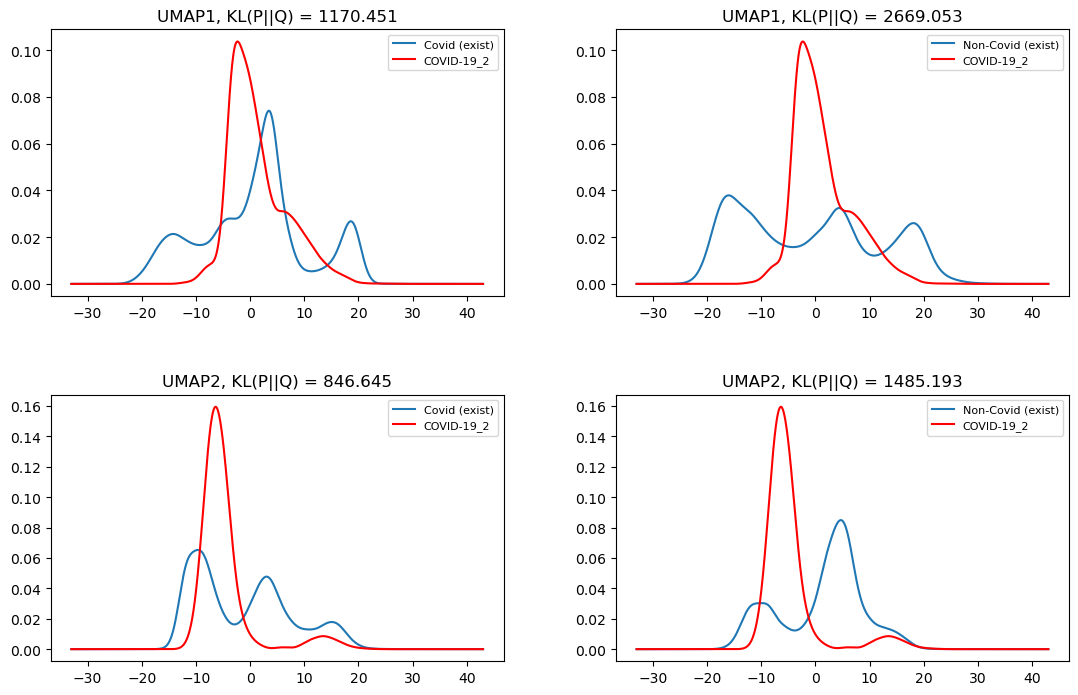

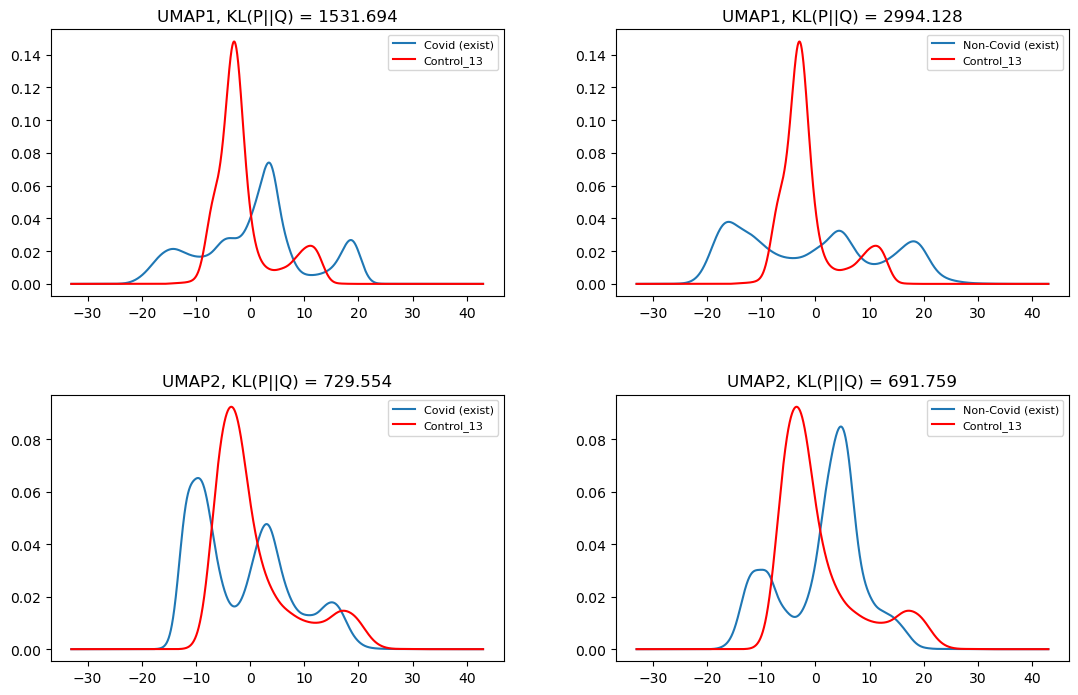

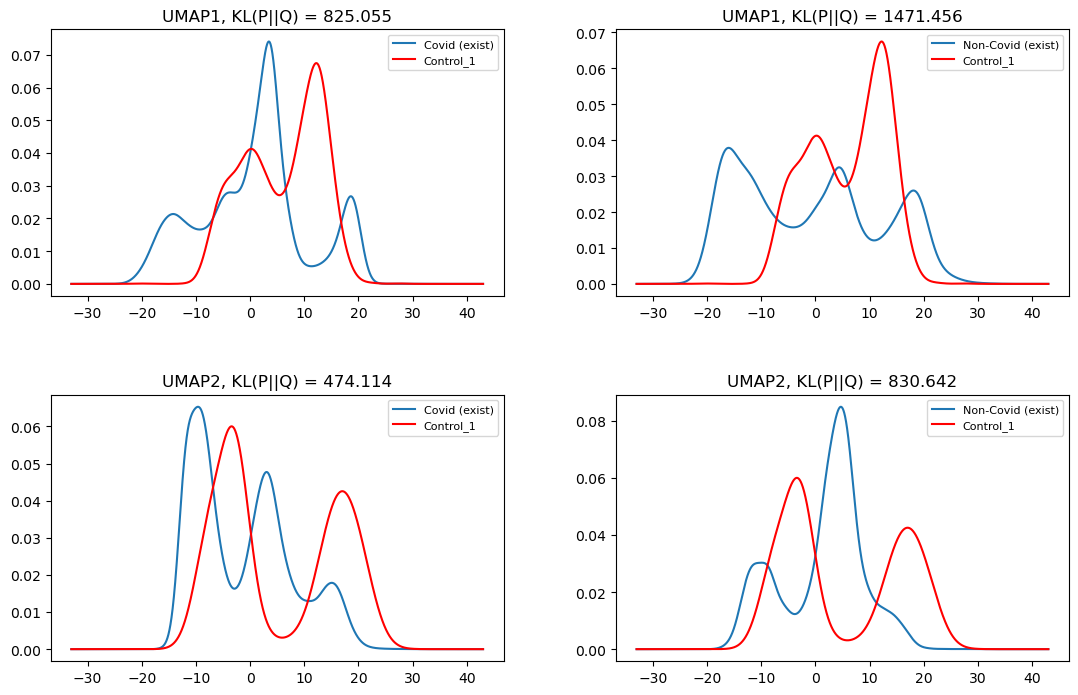

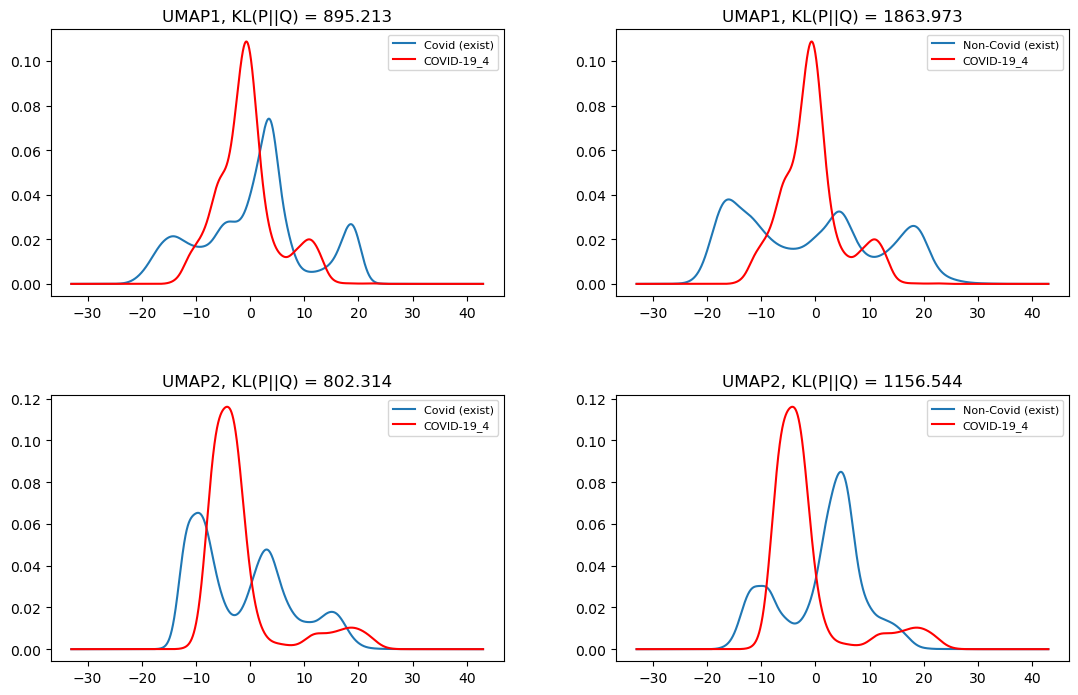

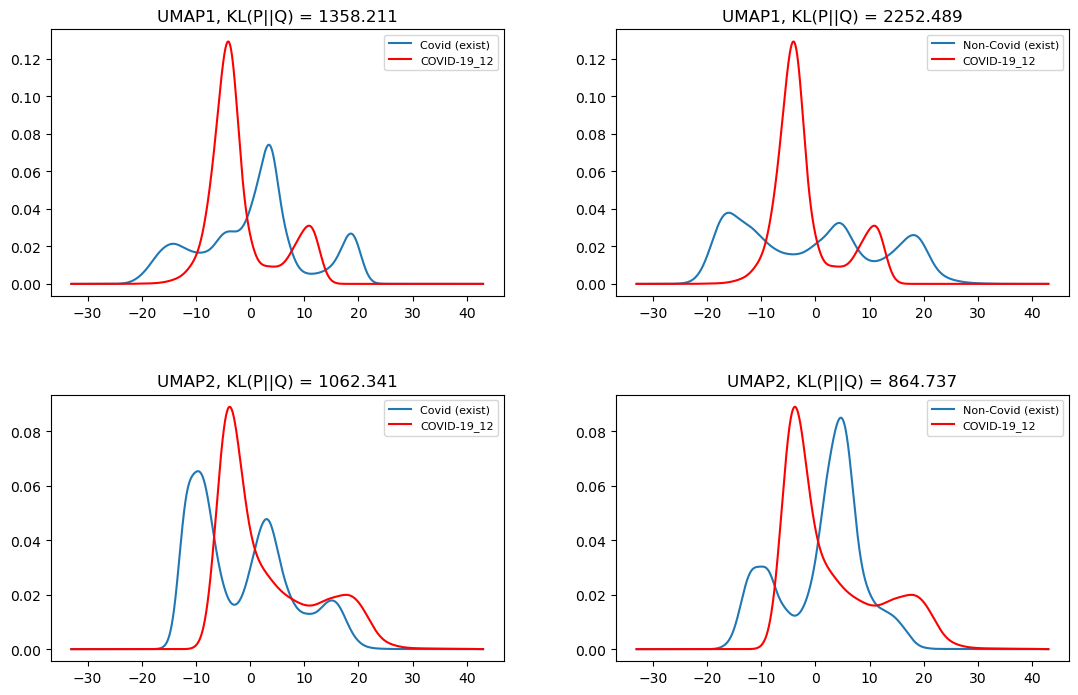

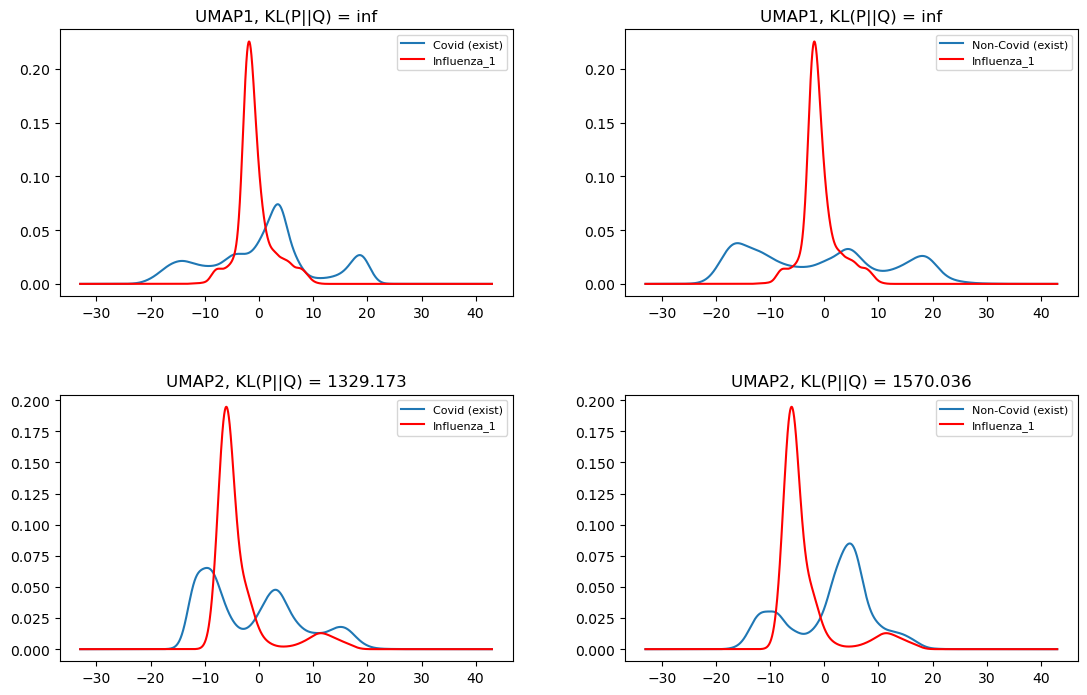

In [41]:
for s, vec in dict_sample_vec.items():
    x_vec = vec[:, 0]
    y_vec = vec[:, 1]

    #Compute kernels of KDE for UMAP1: x-axis and UMAP2: y-axis
    kernel_x = stats.gaussian_kde(x_vec)
    kernel_y = stats.gaussian_kde(y_vec)

    # KDE for UMAP1 (x-axis)
    kde_x_test = kernel_x(n_sample_covid)

    # KDE for UMAP2 (y-axis)
    kde_y_test = kernel_y(n_sample_covid)

    # Get KL-divergence in UMAP 1: x-axis between the existing samples and test sample
    x_KL_d_exis_covid = KL_div(kde_x_covid, kde_x_test)
    x_KL_d_exis_non_covid = KL_div(kde_x_n_covid, kde_x_test)
    # Get KL-divergence in UMAP 2: y-axis between the existing samples and test sample
    y_KL_d_exis_covid = KL_div(kde_y_covid, kde_y_test)
    y_KL_d_exis_non_covid = KL_div(kde_y_n_covid, kde_y_test)

    ### Plot distributions of the existing and test.
    # Initialise the subplot function using number of rows and columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    print(f"Existing sample: covid, Test sample: {s} in UMAP1, KL-divergence: {x_KL_d_exis_covid}")
    axes[0,0].set_title('UMAP1, KL(P||Q) = %1.3f' % x_KL_d_exis_covid)  
    axes[0,0].plot(n_sample_covid, kde_x_covid, label='Covid (exist)')  
    axes[0,0].plot(n_sample_covid, kde_x_test, label=f'{s}', color='red')
    axes[0,0].legend(prop={'size': 8})
    print(f"Existing sample: non_covid, Test sample: {s} in UMAP1, KL-divergence: {x_KL_d_exis_non_covid}")
    axes[0,1].set_title('UMAP1, KL(P||Q) = %1.3f' % x_KL_d_exis_non_covid)  
    axes[0,1].plot(n_sample_covid, kde_x_n_covid, label='Non-Covid (exist)')  
    axes[0,1].plot(n_sample_covid, kde_x_test, label=f'{s}', color='red')
    axes[0,1].legend(prop={'size': 8})

    #result_UMAP1_pred[s] = [x_KL_d_exis_covid, x_KL_d_exis_non_covid]

    print(f"Existing sample: covid, Test sample: {s} in UMAP2, KL-divergence: {y_KL_d_exis_covid}")
    axes[1,0].set_title('UMAP2, KL(P||Q) = %1.3f' % y_KL_d_exis_covid)  
    axes[1,0].plot(n_sample_covid, kde_y_covid, label='Covid (exist)')  
    axes[1,0].plot(n_sample_covid, kde_y_test, label=f'{s}', color='red')
    axes[1,0].legend(prop={'size': 8})
    print(f"Existing sample: non_covid, Test sample: {s} in UMAP2, KL-divergence: {y_KL_d_exis_non_covid}")
    axes[1,1].set_title('UMAP2, KL(P||Q) = %1.3f' % y_KL_d_exis_non_covid)  
    axes[1,1].plot(n_sample_covid, kde_y_n_covid, label='Non-Covid (exist)')  
    axes[1,1].plot(n_sample_covid, kde_y_test, label=f'{s}', color='red')
    axes[1,1].legend(prop={'size': 8})
    #fig.savefig(f"../output_pdfs/dist_compare_{s}_GSE159812.pdf", bbox_inches='tight')

    # To produce a final prediction score, we sum up the KL-divergence score 
    # between UMAP1 and UMAP2, and then divide by 2 to get an average of UMAP1 and UMAP2.
    result_pred[s] = [(x_KL_d_exis_covid+y_KL_d_exis_covid)/2, (x_KL_d_exis_non_covid+y_KL_d_exis_non_covid)/2]

print("--------Done computing KL-divergence with new samples--------")
print("result_pred:", result_pred)

Pick up the index which has the minimum value from each result.

-> If the KL divergence between two distributions is zero, then it indicates that the distributions are identical. Thus, the smaller value is better.

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
y_true = [] # Covid = 0, Non-Covid = 1
y_pred = []

for key, value in result_pred.items():
    if "covid" in key or "COVID" in key:
        y_true.append(0)
    else:
        y_true.append(1)

    print(value)
    y_pred.append(np.argmin(value))

print("Accuracy =", accuracy_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred, average='macro'))
print("Recall = ", recall_score(y_true, y_pred, average='macro'))
print("f1 score = ", f1_score(y_true, y_pred, average='macro'))

[1008.5480713649865, 2077.123137038001]
[1130.6237065164191, 1842.9435360333848]
[649.5842789276214, 1151.0491932944717]
[848.7636875901364, 1510.2584982687495]
[1210.2761277773766, 1558.6128121257607]
[inf, inf]
Accuracy = 0.5
Precision =  0.25
Recall =  0.5
f1 score =  0.3333333333333333


/home/dozonok/anaconda3/envs/workshop_scanpy_2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
